# Thin shell displacements, moho-relief, and strains

This notebook contains a series of examples that detail how to call several functions that solve the [Banerdt (1986)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JB091iB01p00403) thin shell model under different assumptions. Various improvements have been made to the model including the possibility to account for finite-amplitude correction and filtering [(Wieczorek & Phillips, 1998)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/97JE03136), lateral density variations at any arbitrary depth and within the surface, flexure, or moho reliefs [(Wieczorek et al., 2013)](https://science.sciencemag.org/content/early/2012/12/04/science.1231530?versioned=true), and density difference between the surface topography and crust [(Broquet & Wieczorek, 2019)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2019JE005959). 

The model links and outputs 8 parameters expressed in spherical harmonics (degree $l$, order $m$): the topography ($H_{lm}$), geoid at the surface ($G_{lm}$), geoid at the moho depth ($Gc_{lm}$), net acting load on the lithosphere ($q_{lm}$), tangential load potential ($\Omega_{lm}$), flexure of the lithosphere ($w_{lm}$), crustal root variations ($\delta c_{lm}$), and internal density variations ($\delta \rho_{lm}$). 

These 8 parameters are linked through an initial set of 5 equations for $q_{lm}$, $w_{lm}$, $G_{lm}$, $Gc_{lm}$, and $\Omega_{lm}$ (see [Banerdt, 1986](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JB091iB01p00403)). Thus, if 3 conditions are given (e.g., $H_{lm}$, $G_{lm}$, and the assumption that $\delta \rho_{lm}$ = 0), the system will be evenly determined, and the stresses and strains along with the corresponding moho relief can be calculated.

To get started, import the standard *matplotlib* library for graphics, *cmcrameri* for perceptually uniform color maps, *numpy* for mathematical extensions to Python, *pyshtools* (version >= 4.7) for spherical harmonic manipulations and plotting, and the *Displacement_strain_planet* package. 

In [1]:
import os
import matplotlib.pyplot as plt
from cmcrameri import cm
import numpy as np
import pyshtools as pysh
from Displacement_strain_planet import *
# Set the preferred backend to 'ducc'
pysh.backends.select_preferred_backend(backend='ducc', nthreads=0) 

For simplicity, we here we make use of the *pyshtools* package to load the gravity field (spherical harmonic model of [Genova et al., 2016](https://www.sciencedirect.com/science/article/pii/S0019103516001287)) and topography (spherical harmonic model of [Wieczorek et al., 2015](https://www.sciencedirect.com/science/article/pii/B978044453802400169X?via%3Dihub)) of Mars and to perform some spherical harmonics manipulations.

For Mars, the $C_{20}$ coefficient of the topography and gravity are strongly influenced by the planet's rotational flattening. These are generally entirely excluded (or ~95%) for loading calculation as this relief should not be considered as a load.

In [2]:
lmax = 90 # Maximum spherical harmonic degree to perform all calculations
pot_clm   = pysh.datasets.Mars.GMM3(lmax=lmax)  
topo_clm  = pysh.datasets.Mars.MarsTopo2600(lmax=lmax)


R       = topo_clm.coeffs[0,0,0]     # Mean planetary radius
pot_clm = pot_clm.change_ref(r0 = R) # Downward continue to Mean planetary radius

# Compute the geoid as approximated in Banerdt's formulation
geoid_clm = pot_clm * R

# Constants
G      = pysh.constants.G.value        # Gravitational constant
gm     = pot_clm.gm                    # GM given in the gravity model file
mass   = gm / G                        # Mass of the planet
g0     = gm / R**2                     # Mean gravitational attraction of the planet


# Remove 100% of C20
percent_C20 = 0. 
topo_clm.coeffs[0,2,0]  = (percent_C20 /100.) * topo_clm.coeffs[0,2,0]
geoid_clm.coeffs[0,2,0] = (percent_C20 /100.) * geoid_clm.coeffs[0,2,0]

We set some initial parameters for the upcoming inversion and send it to arguments. 

In [3]:
# Parameters
c    = 50e3    # Mean Crustal thickness
Te   = 100e3   # Elastic thickness
rhom = 3500.   # Mantle density
rhoc = 2800.   # Crustal density
rhol = 2800.   # Surface density
E    = 100e9   # Young's modulus
v    = 0.25    # Poisson's ratio

args_param_m   = (g0, R, c, Te, rhom, rhoc, rhol, lmax, E, v, mass)
args_expand = dict(lmax = 5*lmax, lmax_calc = lmax)
args_fig = dict(figsize=(12,10), dpi= 100)

We define some initial arrays for the examples below. 
`zeros` is a spherical harmonic array of zeros. 
`drhom_lm_plume` is an example array with spherical harmonic coefficients for a mantle plume with a density contrast of -30 kg m$^{-3}$, which tapers at about 1000 km radius, located underneath Tharsis.

In [4]:
path = '%s/data' %(os.getcwd())
zeros          = pysh.SHCoeffs.from_zeros(lmax = lmax).coeffs
drhom_lm_plume = pysh.SHCoeffs.from_file('%s/Example_plume_coeffs_clm.txt' %(path))
drhom_lm_plume = drhom_lm_plume.pad(lmax = lmax).coeffs

## Displacements using global present-day gravity and topography

### Compensation by crustal root variations and displacements

In this example, we solve for the displacement of the surface of Mars by calling the function `Thin_shell_matrix_nmax`, assuming that the gravity and topography of the planet are compensated by a combination of crustal root variations and flexure. 3 assumptions are required to solve the system, and we here assume that the observed topography and geoid are known (`H_lm = topo_clm.coeffs, G_lm = geoid_clm.coeffs`), and that there are no density variations in the interior (`drhom_lm = zeros.copy()`).

By default, the code accounts for finite-amplitude corrections and solve the model in an iterative manner. More informations, including crustal thickness values at each iterations, can be printed by setting the optional parameter `quiet` to `False`. We will also make use of a downward continuation minimum-amplitude filter to damp unrealistic oscillations of the moho-relief [Wieczorek & Phillips (1998)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/97JE03136). For this, we call the optional argument `filter`, set it to `'Ma'`, and set the degree at which the filter equals 0.5 to 50 with a call to `filter_half`. The user can also input any given filter using the argument `filter_in`.

The function outputs the following spherical harmonic coefficients: \
`w_lm` flexure (defined positive upward), \
`A_lm` poloidal term of the tangential displacement,  \
`moho_relief_lm` moho relief,  \
`dc_lm` crustal root variations (defined negative upward),  \
`drhom_lm` internal density variations,  \
`omega_lm` tangential load potential,  \
`q_lm` net load on the lithosphere,  \
`Gc_lm` geoid at the moho depth,  \
`G_lm` geoid at the surface, and \
`H_lm` topography.

And the linear solution `sols` are expressed as lambda functions (size lmax+1) of all components. Lambda functions can be used to re-calculate the same problem with different inputs very fast.

In [5]:
(w_lm, A_lm, moho_relief_lm, dc_lm, drhom_lm, omega_lm, q_lm, Gc_lm,
G_lm, H_lm, sols) = Thin_shell_matrix_nmax(*args_param_m, G_lm = geoid_clm.coeffs,
        H_lm = topo_clm.coeffs, drhom_lm = zeros.copy(), filter = 'Ma', filter_half = 50)

We next plot $w_{lm}$, $\delta c_{lm}$, $\delta \rho_{lm}$, and the moho-relief ($\delta c_{lm} - w_{lm}$). For the moho-relief, we will add the topography coefficients (`H_lm`).

For the plots, we make use of the *pyshtools* software to convert the spherical harmonic arrays to a `SHCoeffs` class, convert it to a grid, and plot the results. For the upper left figure plot, we added a zero contour to delimit where the displacement is negative and positive.

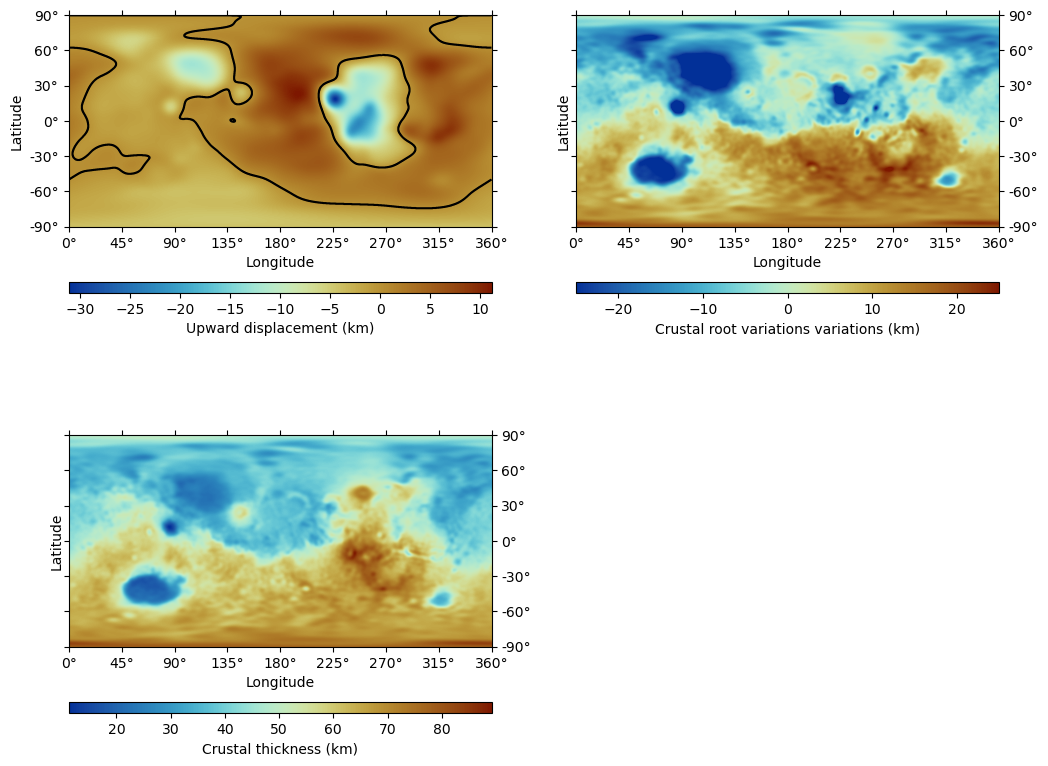

In [6]:
args_plot = dict(tick_interval=[45, 30], colorbar = 'bottom', cmap = cm.roma_r)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, **args_fig)

grid_W = pysh.SHCoeffs.from_array(w_lm/1e3).expand(**args_expand) - R/1e3
grid_W.plot(ax=ax1, cb_label = 'Upward displacement (km)', **args_plot)
ax1.contour(grid_W.data > 0, levels = [0.99], extent = (0,360,-90,90), 
        colors = 'k', origin = 'upper') # Add zero displacement contour
pysh.SHCoeffs.from_array(dc_lm/1e3).expand(**args_expand).plot(ax=ax2, 
        cb_label = 'Crustal root variations variations (km)', 
        ticks = 'wSnE', **args_plot, cmap_limits = [-25,25])
(pysh.SHCoeffs.from_array((H_lm-moho_relief_lm)/1e3).expand(**args_expand)).\
        plot(ax=ax3, cb_label = 'Crustal thickness (km)', ticks = 'wSnE', 
        show = True, **args_plot)
ax4.set_visible(False)

### Comparison with the mass-sheet case

By default, the `Thin_shell_matrix_nmax` function computes the non-linear finite-amplitude corrections in an iterative manner. Let's compare what the difference would be assuming a mass-sheet case, which can be obtained by setting the optional `nmax` parameter to 1. Setting `nmax` to 1 significantly fasten all computations.

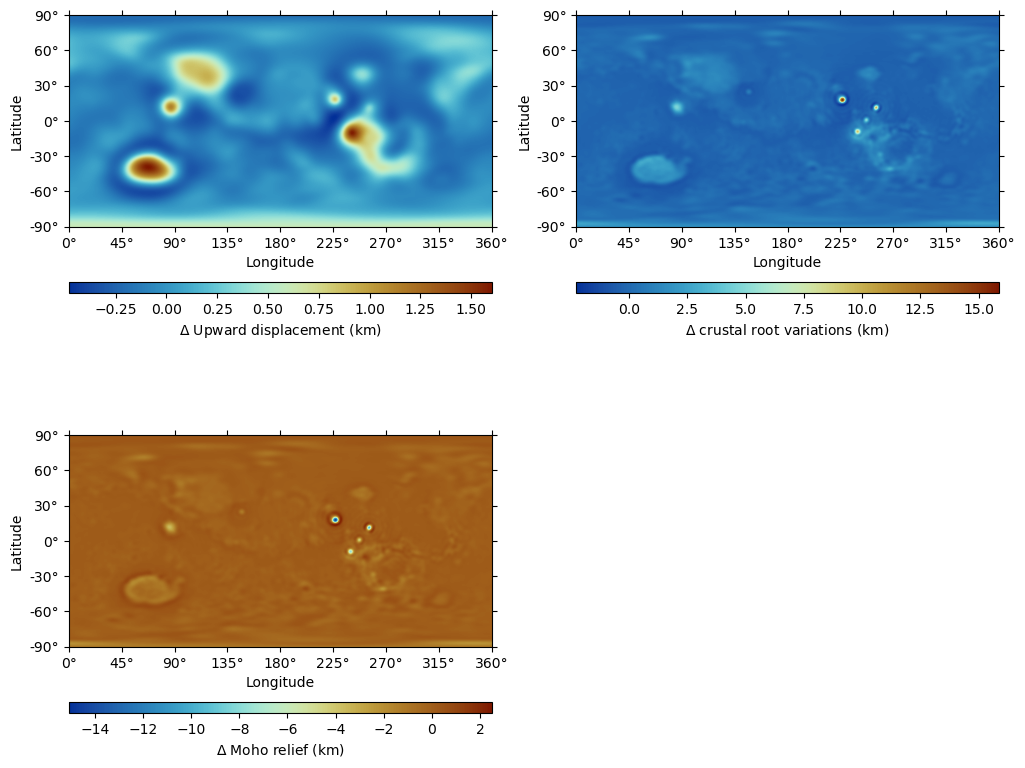

In [7]:
(w_lm_n1, A_lm_n1, moho_relief_lm_n1, dc_lm_n1, drhom_lm_n1, omega_lm_n1, 
q_lm_n1, Gc_lm_n1, G_lm_n1, H_lm_n1, sols) = Thin_shell_matrix_nmax(*args_param_m, 
        G_lm = geoid_clm.coeffs, H_lm = topo_clm.coeffs, drhom_lm = zeros.copy(), nmax = 1, 
        filter = 'Ma', filter_half = 50)

args_plot = dict(tick_interval=[45, 30], colorbar = 'bottom', cmap = cm.roma_r)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, **args_fig)

W_diff = pysh.SHCoeffs.from_array((w_lm-w_lm_n1)/1e3).expand(**args_expand)
W_diff.plot(ax=ax1, cb_label = '$\\Delta$ Upward displacement (km)', **args_plot)
pysh.SHCoeffs.from_array((dc_lm-dc_lm_n1)/1e3).expand(**args_expand).plot(ax=ax2, 
        cb_label = '$\\Delta$ crustal root variations (km)', **args_plot)
(pysh.SHCoeffs.from_array(((moho_relief_lm-moho_relief_lm_n1))/1e3).expand(**args_expand)).\
        plot(ax=ax3, cb_label = '$\\Delta$ Moho relief (km)', show = True, **args_plot)
ax4.set_visible(False)

### Pratt compensation (crustal density variations)

In this example, we will assume that the observed topography and geoid of Mars are compensated by density variations in the crust only (i.e., Pratt isostasy). In that case, we need to input 2 parameters: $H_{lm}$, $G_{lm}$, and set both $\delta c_{lm}$ and $w_{lm}$ to zero. The density contrast is located between the moho depth and surface, and we thus set the 2 optional parameters `top_drho` and `base_drho` to `0` (surface depth) and `c` (moho depth).

With these 4 inputs, the model becomes overdetermined (4 unknowns, 5 equations). One option is to remove an equation from the system. For consistency, we will here remove one of the five equations that is not that of an input parameter. The simplest way to do that is to use the argument `remove_equation` of the function and set it to, for example, `'Gc_lm'`. 

**Note that it is possible that the system gives different outputs as a function of the equation that is removed (e.g., if we remove `G_lm`)**. 

**Note that Pratt isostasy could also be viewed as only requiring that there is no crustal root variations (i.e., only setting $\boldsymbol{\delta c_{lm}}$ to zero).**

A simple sanity check can be performed for the case of Pratt compensation. This requires setting the elastic thickness (`Te`) to a large value in order to have almost zero displacement, in which case compensation would only occur by density variations. For large elastic thicknesses, it is thus not necessary to set $w_{lm}$ to zero and to remove an equation. 

As demonstrated below, both approaches give roughly the same results. Slight differences are due to a long-wavelength residual displacement (due to the elastic thickness not being infinite), finite-amplitude corrections, and variations in density within the surface relief making the equations non-linear (short-wavelength differences).

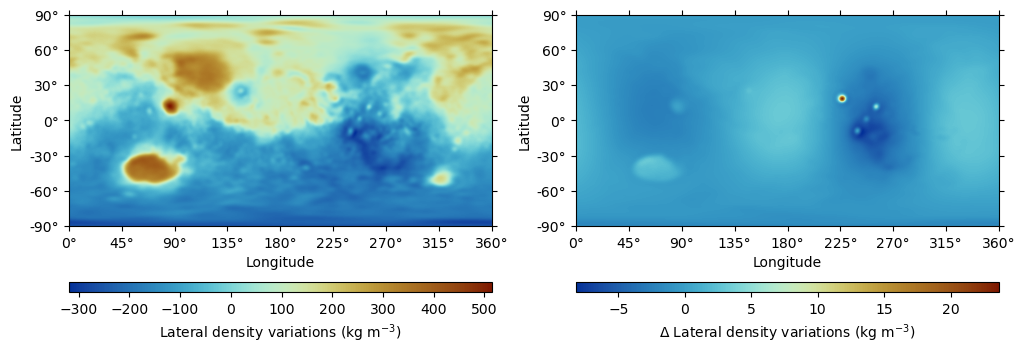

In [8]:
top_drho = 0.
base_drho = c

(w_lm, A_lm, moho_relief_lm, dc_lm, drhom_lm, omega_lm, q_lm, Gc_lm, 
G_lm, H_lm, sols) = Thin_shell_matrix_nmax(*args_param_m, top_drho = top_drho, 
        base_drho = base_drho, G_lm = geoid_clm.coeffs, H_lm = topo_clm.coeffs, 
        dc_lm = zeros.copy(), w_lm = zeros.copy(), remove_equation = 'Gc_lm',
        filter = "Ma", filter_half = 50)

# Alternative Te = 2000 km comparing drhom_lm
drhom_lm_Te = Thin_shell_matrix_nmax(g0, R, c, 2000e3, rhom, rhoc, rhol, 
        lmax, E, v, mass, top_drho = top_drho, base_drho = base_drho, 
        G_lm = geoid_clm.coeffs, H_lm = topo_clm.coeffs, dc_lm = zeros.copy(),                      
        filter = 'Ma', filter_half = 50)[4]

### Plotting
args_plot = dict(tick_interval=[45, 30], colorbar = 'bottom', cmap = cm.roma_r)
fig, (ax1,ax2) = plt.subplots(1,2, **args_fig)

pysh.SHCoeffs.from_array(drhom_lm).expand(**args_expand).plot(ax=ax1, 
        cb_label = 'Lateral density variations (kg m$^{-3}$)', **args_plot)
pysh.SHCoeffs.from_array(drhom_lm-drhom_lm_Te).expand(**args_expand).plot(ax=ax2, 
        cb_label = '$\\Delta$ Lateral density variations (kg m$^{-3}$)', show = True,
        **args_plot)

### Airy compensation (crustal thickness variations)

In this example, we will assume that the observed topography and geoid of Mars are compensated by crustal thickness variations (i.e., Airy isostasy). Airy isostasy is achieved when there is no internal density variations and when the elastic thickness is zero. 

**Note that in order to avoid numerical problems, when the elastic thickness is zero, the function internally sets it to 1 m.**

**Note that Airy isostasy could also be viewed as only requiring that there is no internal density variations (i.e., only setting $\boldsymbol{\delta \rho_{lm}}$ to zero).**

! Warning:Thin_shell_matrix, elastic thickness set to 1 m to avoid numerical problems !
! Warning:Thin_shell_matrix, elastic thickness set to 1 m to avoid numerical problems !


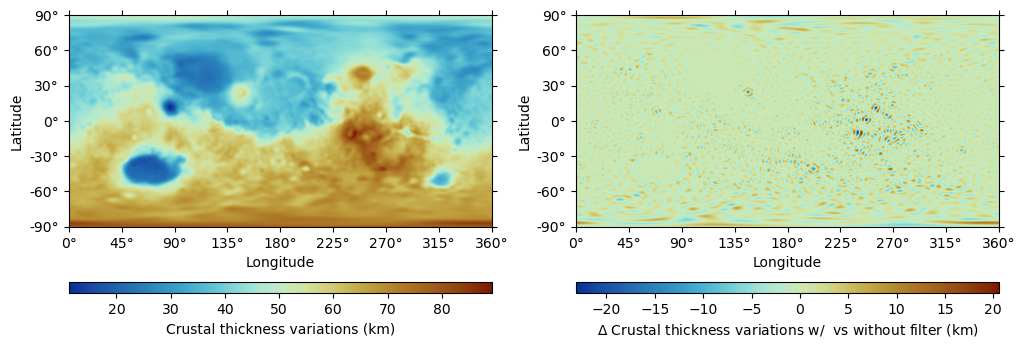

In [9]:
args_param_m_Te0   = (g0, R, c, 0, rhom, rhoc, rhol, lmax, E, v, mass)

(w_lm, A_lm, moho_relief_lm, dc_lm, drhom_lm, omega_lm, q_lm, Gc_lm, 
G_lm, H_lm, sols) = Thin_shell_matrix_nmax(*args_param_m_Te0, 
        G_lm = geoid_clm.coeffs, H_lm = topo_clm.coeffs, 
        drhom_lm = zeros.copy(), filter = 'Ma', filter_half = 50)

# Difference without filter
moho_relief_lm_no_filter = Thin_shell_matrix_nmax(*args_param_m_Te0, 
        G_lm = geoid_clm.coeffs, H_lm = topo_clm.coeffs, drhom_lm = zeros.copy())[2]

### Plotting
args_plot = dict(tick_interval=[45, 30], colorbar = 'bottom', 
        cmap = cm.roma_r)
fig, (ax1,ax2) = plt.subplots(1,2, **args_fig)

pysh.SHCoeffs.from_array((H_lm-moho_relief_lm)/1e3).expand(**args_expand).plot(ax=ax1, 
        cb_label = 'Crustal thickness variations (km)', **args_plot)
(pysh.SHCoeffs.from_array((moho_relief_lm-moho_relief_lm_no_filter)/1e3).expand(**args_expand)).\
        plot(ax=ax2, cb_label = ('$\\Delta$ Crustal thickness variations w/ ' +
        ' vs without filter (km)'), show = True,**args_plot)

## Displacements only due to a plume underneath Tharsis

In this example, we will solve for the displacement assuming that a plume is located underneath an elastic shell of thickness `Te`. All parameters but the density variations associated with the plume (`drhom_lm`) are unknown. In that case, the system is largely underdetermined and we need a few assumptions.  

1) The first assumption is that there will be no crustal root variations, and we set $\delta c_{lm}$ to zero. 

2) A second assumption is that the plume will give rise to dynamic topography only. In that case, we want $H_{lm} = w_{lm}$ or $H_{lm} - w_{lm} = 0$. The function allows the user to add an equation to the system, and the required assumption is obtained by setting the optional argument `add_equation` to be equal to `'H_lm - w_lm'` (the system automatically assumes it is equal to zero). We note that any linear equation that links one (or more) of the 8 parameters can be input.

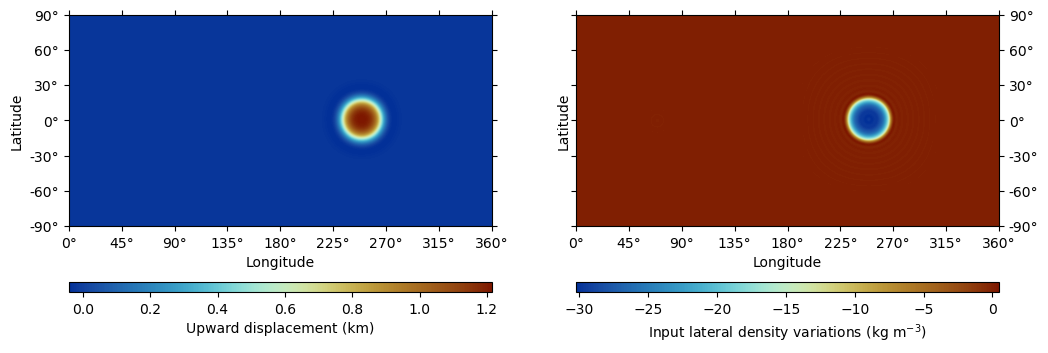

In [10]:
plume_thickness = 150e3 # Thickness of the mantle plume
top_drho = Te
base_drho = Te + plume_thickness

(w_lm, A_lm, moho_relief_lm, dc_lm, drhom_lm, omega_lm, q_lm, Gc_lm, 
G_lm, H_lm, sols) = Thin_shell_matrix_nmax(*args_param_m, top_drho = 
        top_drho, base_drho = base_drho, drhom_lm = drhom_lm_plume, 
        dc_lm = zeros.copy(), add_equation = 'H_lm - w_lm')

### Plotting
args_plot = dict(tick_interval=[45, 30], colorbar = 'bottom', cmap = cm.roma_r)
fig, (ax1,ax2) = plt.subplots(1,2, **args_fig)

(pysh.SHCoeffs.from_array(w_lm/1e3).expand(**args_expand) - R/1e3).plot(ax=ax1, 
        cb_label = 'Upward displacement (km)', **args_plot)
pysh.SHCoeffs.from_array(drhom_lm).expand(**args_expand).plot(ax=ax2, 
        cb_label = 'Input lateral density variations (kg m$^{-3}$)', ticks = 'wSnE',
        show = True, **args_plot)

## More complex `add_equation` option

### Degree-dependent compensation

Let's make a funny example where we force the model to compensate the degree-1 loads by crustal density variations and the rest by crustal thickness variations to show an additional possibility in the function. In that case, the additional equation becomes `'(w_lm - dc_lm) * add_array1 + drhom_lm * add_array2'`, where `'add_array1'` and `'add_array2'` contain the necessary spherical harmonic coefficients (see below), which are passed through the argument `add_arrays`. More arrays can be input as `'add_array3'`, `'add_array4'` and so on. All must be with shape equal to the input constraints `(2,lmax+1,lmax+1)`. 

**Important note:** 
1) For multiplications in `add_equation`, we only use the `(0,lmax+1,0)` terms of each `add_arrays`. All terms `(2,lmax+1,lmax+1)` are used with additions or substractions.

2) Multiplications in `add_equation` can generate problems when used with finite-amplitude correction (`nmax != 1`). For example, this will introduce correction terms beyond degree-1 for drhom_lm, which is not consistent with the input equation.

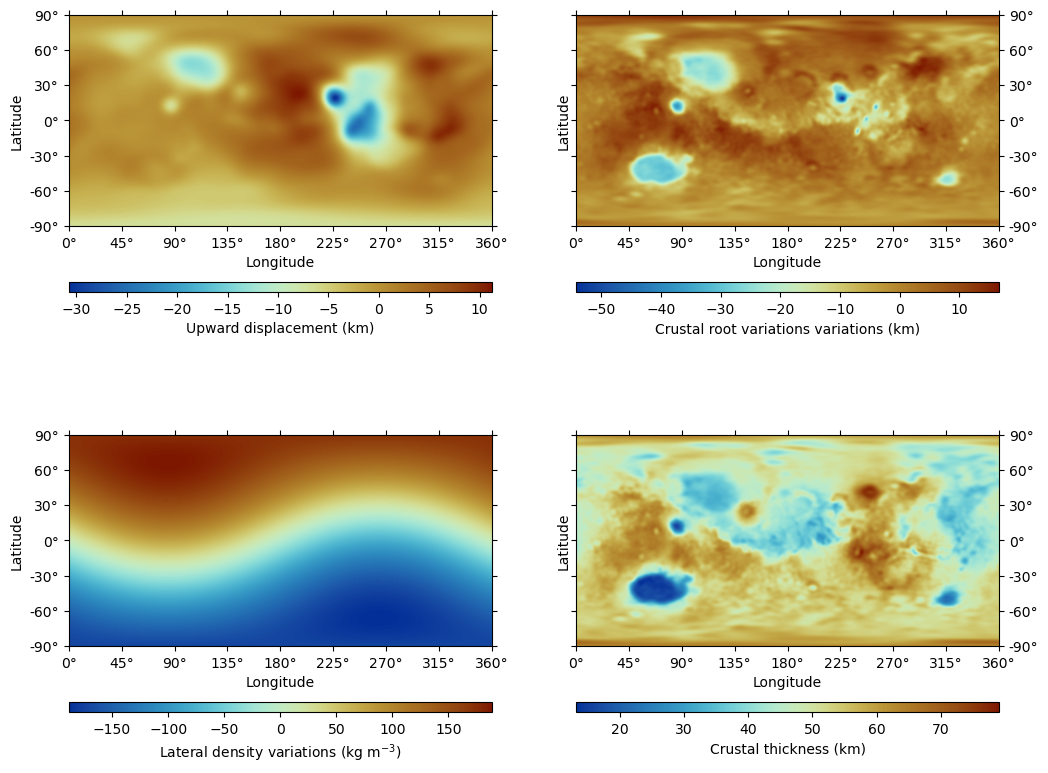

In [11]:
top_drho = 0.
base_drho = c
add_equation = '(w_lm - dc_lm) * add_array1 + drhom_lm * add_array2'

add_arrays = np.zeros((2, 2,lmax+1,lmax+1))
add_arrays[0,0,1,0] = 1 # add_array1 is 1 at degree 1 implying w_lm - dc_lm = 0
add_arrays[1,:,:,:] = 1 # add_array is 0 everywhere (implying drhom_lm = 0) but at degree 1.
add_arrays[1,0,1,0] = 0

(w_lm, A_lm, moho_relief_lm, dc_lm, drhom_lm, omega_lm, q_lm, Gc_lm,
G_lm, H_lm, sols) = Thin_shell_matrix_nmax(*args_param_m, G_lm = geoid_clm.coeffs, 
        H_lm = topo_clm.coeffs, base_drho = base_drho, top_drho = top_drho, 
        add_equation = add_equation, 
        add_arrays = add_arrays, filter = 'Ma', filter_half = 50)

### Plotting
args_plot = dict(tick_interval=[45, 30], colorbar = 'bottom', cmap = cm.roma_r)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, **args_fig)

(pysh.SHCoeffs.from_array(w_lm/1e3).expand(**args_expand) - R/1e3).plot(ax=ax1,
        cb_label = 'Upward displacement (km)', **args_plot)
pysh.SHCoeffs.from_array(dc_lm/1e3).expand(**args_expand).plot(ax=ax2,
        cb_label = 'Crustal root variations variations (km)',
        ticks = 'wSnE', **args_plot)
pysh.SHCoeffs.from_array(drhom_lm).expand(**args_expand).plot(ax=ax3,
        cb_label = 'Lateral density variations (kg m$^{-3}$)', **args_plot)
(pysh.SHCoeffs.from_array((H_lm-moho_relief_lm)/1e3).expand(**args_expand)).\
        plot(ax=ax4, cb_label = 'Crustal thickness (km)', ticks = 'wSnE',
        show = True, **args_plot)

### Internal load in phase with surface topography

In this last example, we will assume that part of the bottom loading is due to an internal density anomaly located between the surface and 100 km depth. As the surface load depends on the unknown flexure, the easiest is to use the argument `add_equation` and set it to `'drhom_lm * M - L * rhol * (H_lm - G_lm - w_lm)'` where `L` is the load ratio set to 0.10, and `M` is the internal load thickness set to 100 km.

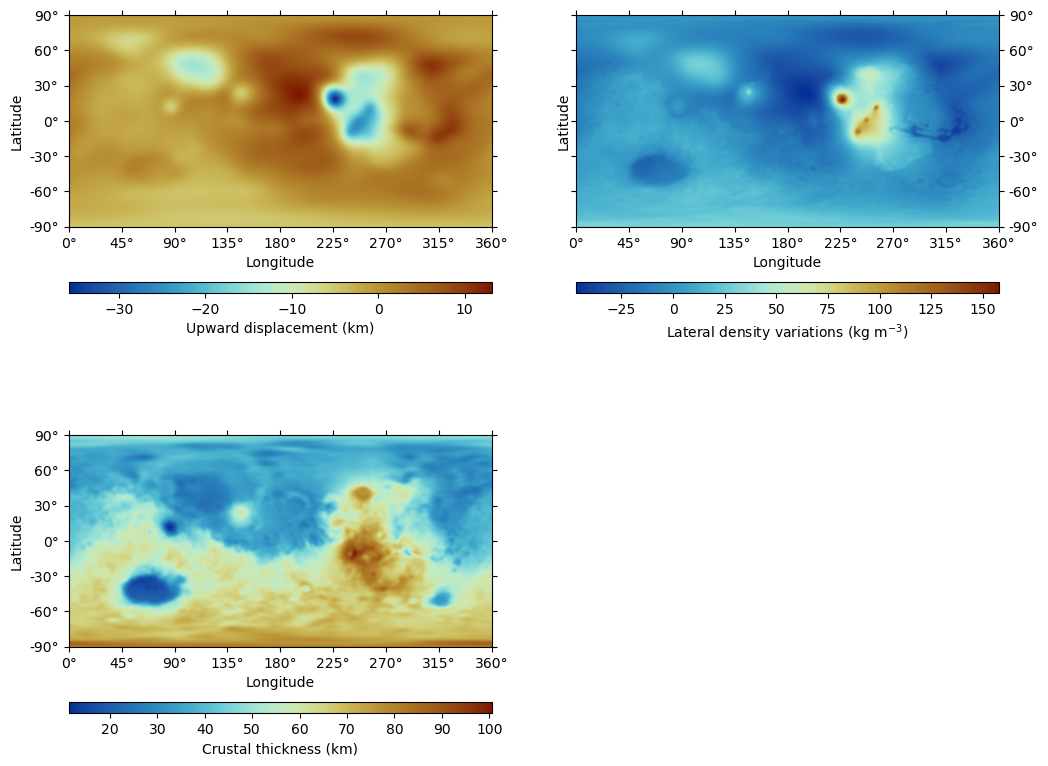

In [12]:
load_thickness = 100e3
L_ratio = 0.1
add_equation = 'drhom_lm - (%s * %s * (H_lm - G_lm - w_lm)) / %s' %(L_ratio, rhol, load_thickness)

(w_lm, A_lm, moho_relief_lm, dc_lm, drhom_lm, omega_lm, q_lm, Gc_lm, 
G_lm, H_lm, sols) = Thin_shell_matrix_nmax(*args_param_m, base_drho = Te+load_thickness, 
        top_drho = Te, G_lm = geoid_clm.coeffs, H_lm = topo_clm.coeffs, 
        add_equation = add_equation, filter = "Ma", filter_half = 50)

### Plotting
args_plot = dict(tick_interval=[45, 30], colorbar = 'bottom', cmap = cm.roma_r)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, **args_fig)

(pysh.SHCoeffs.from_array(w_lm/1e3) - R/1e3).expand(**args_expand).plot(ax=ax1, 
        cb_label = 'Upward displacement (km)', **args_plot)
pysh.SHCoeffs.from_array(drhom_lm).expand(**args_expand).plot(ax=ax2, 
        cb_label = 'Lateral density variations (kg m$^{-3}$)',  
        ticks = 'wSnE', **args_plot)
(pysh.SHCoeffs.from_array((H_lm-moho_relief_lm)/1e3).expand(**args_expand)).\
        plot(ax=ax3, cb_label = 'Crustal thickness (km)', show = True, **args_plot)
ax4.set_visible(False)

## Stresses and strains

Here, we make use of the predicted displacement `w_lm` and the poloidal term of the tangential displacement `A_lm`, from the first example, to predict stresses and strains on the lithosphere using the function call `Displacement_strains`. 

First, we call the `SH_deriv_store` function  that precomputes Legendre polynomial derivates on a planet's surface. These will be used to compute stresses and strains. Depending on `lmax`, this may take some time as an array of size `(2,(lmax+1)*(lmax+2)/2)` is computed at each latitude and longitude points on the planet. The user may input the optional parameters `lmaxgrid` and `grid` to determine the kind of grid (DH or GLQ) and size. Once loaded, these can be saved at a given `path` location, when `save = True`, but we note that the size of the file can be quite large (e.g., `lmax` = 50, filesize = 1.3 GB). File size can be reduced by compressing the file (`compressed = True`) or changing the data type (e.g., `dtype = np.float32` instead of default `np.float64`). The later strains and stresses will be computed only within `colat_min`, `colat_max`, `lon_min`, and `lon_max`.

In [13]:
# Precompute Legendre Polynomial derivatives for strain calculations
lmax = 50 # Lower lmax for faster computations
lmaxgrid = 150
Y_lm_d1_t, Y_lm_d1_p, Y_lm_d2_t, Y_lm_d2_p, Y_lm_d2_tp, y_lm = \
    SH_deriv_store(lmax, path, lmaxgrid = lmaxgrid, save = False)

# Whole planet
colat_min = 0    # Minimum colatitude at which strain calculations are performed
colat_max = 180  # Maximum colatitude
lon_min   = 0    # Minimum longitude
lon_max   = 360  # Maximum longitude

args_param_s = (E, v, R, Te, lmax)
kwargs_param_s = dict(colat_min = colat_min, colat_max = colat_max, 
        lon_min = lon_min, lon_max = lon_max, Y_lm_d1_t = Y_lm_d1_t, 
        Y_lm_d1_p = Y_lm_d1_p, Y_lm_d2_t = Y_lm_d2_t, Y_lm_d2_p = Y_lm_d2_p, 
        Y_lm_d2_tp = Y_lm_d2_tp, y_lm = y_lm, lmaxgrid = lmaxgrid)

The `Displacement_strains` function outputs stresses as a function of colatitude ($\theta$) and longitude ($\phi$) as: $\sigma_{\theta}$ = `stress_theta`, $\sigma_{\phi}$ = `stress_phi`, and $\sigma_{\theta\phi}$ = `stress_theta_phi`. Elongation and sheering deformations of the middle surface of the shell are given by: $\varepsilon_{\theta}$ = `eps_theta`, $\varepsilon_{\phi}$ = `eps_phi`, and $\varepsilon_{\theta\phi}$ = `omega`. Bending and twisting deformation of the shell are given by: $\kappa_{\theta}$ = `kappa_theta`, $\kappa_{\phi}$ = `kappa_phi`, $\kappa_{\theta\phi}$ = `tau`. The total deformation is given by `tot_theta`, `tot_phi`, and `tot_thetaphi`. As specified in `kwargs_param_s`, the strain will be computed only within the input `min_lon`, `max_lon, `min_lat, `max_lat`.

**In these scripts, compression is defined to be negative.**

The strains are then rotated into their principal components using the function call `Principal_strainstress_angle` to output the minimum, maximum, and sum of the principal horizontal strains (min_strain, max_strain, sum_strain). The function also outputs the principal strain angle `principal_angle`.

In [14]:
# Recompute parameters assuming compensation due to crustal root
# variations and displacement (first example)
(w_lm, A_lm, moho_relief_lm, dc_lm, drhom_lm, omega_lm, q_lm, Gc_lm, 
G_lm, H_lm, sols) = Thin_shell_matrix_nmax(*args_param_m, G_lm = geoid_clm.coeffs, 
        H_lm = topo_clm.coeffs, drhom_lm = zeros.copy())
# Strain
(stress_theta, stress_phi, stress_theta_phi, eps_theta, eps_phi, 
omega, kappa_theta, kappa_phi, tau, tot_theta, tot_phi, tot_thetaphi) = Displacement_strains(A_lm, w_lm, 
        *args_param_s, **kwargs_param_s)

# Principal strains
min_strain, max_strain, sum_strain, principal_angle = \
        Principal_strainstress_angle(-tot_theta, -tot_phi, -tot_thetaphi)

### Plotting

In `ax3` and `ax4`, we plot the extensional tectonic features mapped by [Knampeyer et al. (2006)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006JE002708). They are seen to nicely cluster where the model predicts extension (plotted negative), and follow the rotational pattern given by the principal strain angle.

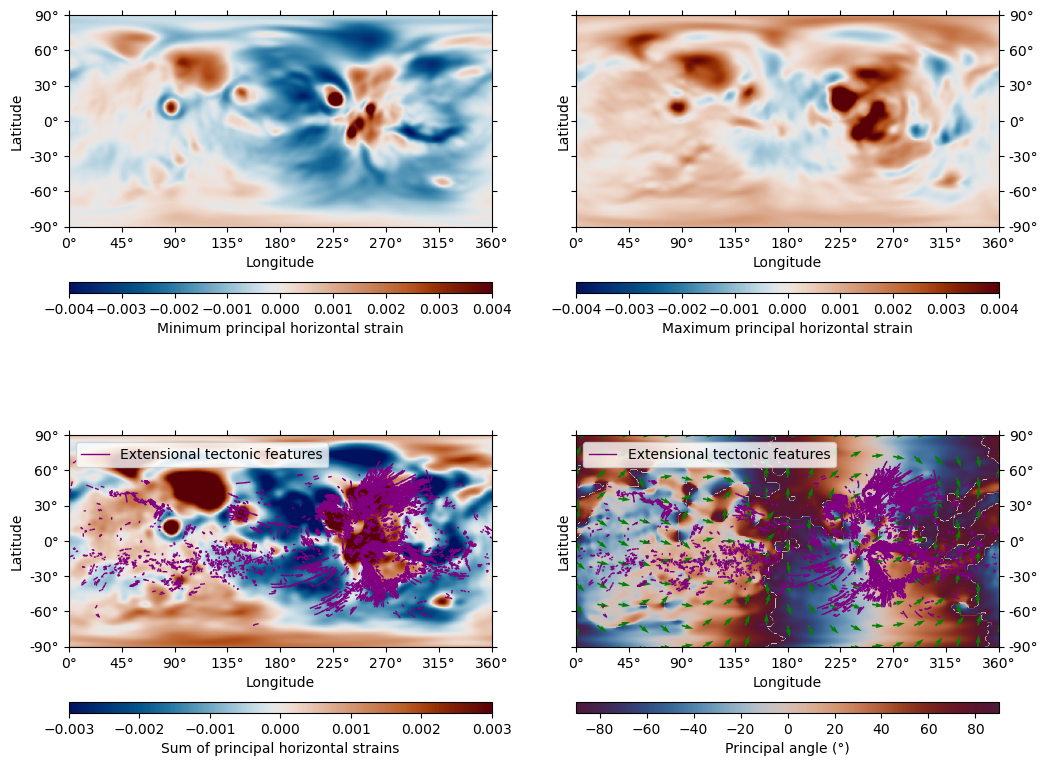

In [15]:
args_plot = dict(tick_interval=[45, 30], colorbar = 'bottom', cmap = cm.vik)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, **args_fig)

pysh.SHGrid.from_array(min_strain).plot(ax=ax1, 
        cb_label = 'Minimum principal horizontal strain', cmap_limits = 
        [-4e-3, 4e-3], cb_tick_interval = 1e-3, **args_plot)
pysh.SHGrid.from_array(max_strain).plot(ax=ax2, 
        cb_label = 'Maximum principal horizontal strain', ticks = 'wSnE', 
        cmap_limits = [-4e-3, 4e-3], cb_tick_interval = 1e-3, 
        **args_plot)
pysh.SHGrid.from_array(sum_strain).plot(ax=ax3, cb_label = 
        'Sum of principal horizontal strains', cmap_limits = [-3e-3, 3e-3], 
        cb_tick_interval = 1e-3, **args_plot)
pysh.SHGrid.from_array(principal_angle).plot(ax=ax4, cb_label = 
        'Principal angle (°)', ticks = 'wSnE', 
        cmap_limits = [-90, 90], tick_interval=[45, 30], 
        colorbar = 'bottom', cmap = cm.vikO)

# Plot strain direction
skip_i = int(lmaxgrid / 10)
skip =(slice(None,None,skip_i),slice(None,None,skip_i))
grid_long, grid_lat = np.meshgrid(np.linspace(0,360,np.shape(principal_angle)[1]),
        np.linspace(90,-90,np.shape(principal_angle)[0]))
ones = np.ones(np.shape(principal_angle))
ax4.quiver(grid_long[skip], grid_lat[skip], ones[skip], ones[skip], scale = 5e1, 
           angles = principal_angle[skip], color = 'g')

# Add the Knapmeyer et al. (2006) mapping of extensional tectonic features
Plt_tecto_Mars(path, ax = [ax3,ax4], extension = True, compression = False)
plt.show()